In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# 读取快照数据
df = pd.read_pickle(r'log\rmsc03_two_hour\SNAPSHOT_AGENT.bz2')
df = df.reset_index()
df

,EventTime,EventType,Event
0,NaT,AGENT_TYPE,SnapshotAgent
1,NaT,STARTING_CASH,100000
2,2025-11-14 00:00:00.000000000,HOLDINGS_UPDATED,{'CASH': 100000}
3,2025-11-14 09:30:01.009769548,BID_DEPTH,"[(3731, 325), (3730, 77), (3729, 73), (3728, 1..."
4,2025-11-14 09:30:01.009769548,ASK_DEPTH,"[(3732, 1203), (3733, 33), (3736, 47), (3738, ..."
...,...,...,...
5402,2025-11-14 09:45:00.009769598,VOLUME,"{'timestamp': 2025-11-14 09:45:00.009769598, '..."
5403,2025-11-14 09:45:00.009769598,FINAL_HOLDINGS,{ CASH: 100000 }
5404,2025-11-14 09:45:00.009769598,FINAL_CASH_POSITION,100000
5405,2025-11-14 09:45:00.009769598,MARKED_TO_MARKET,100000


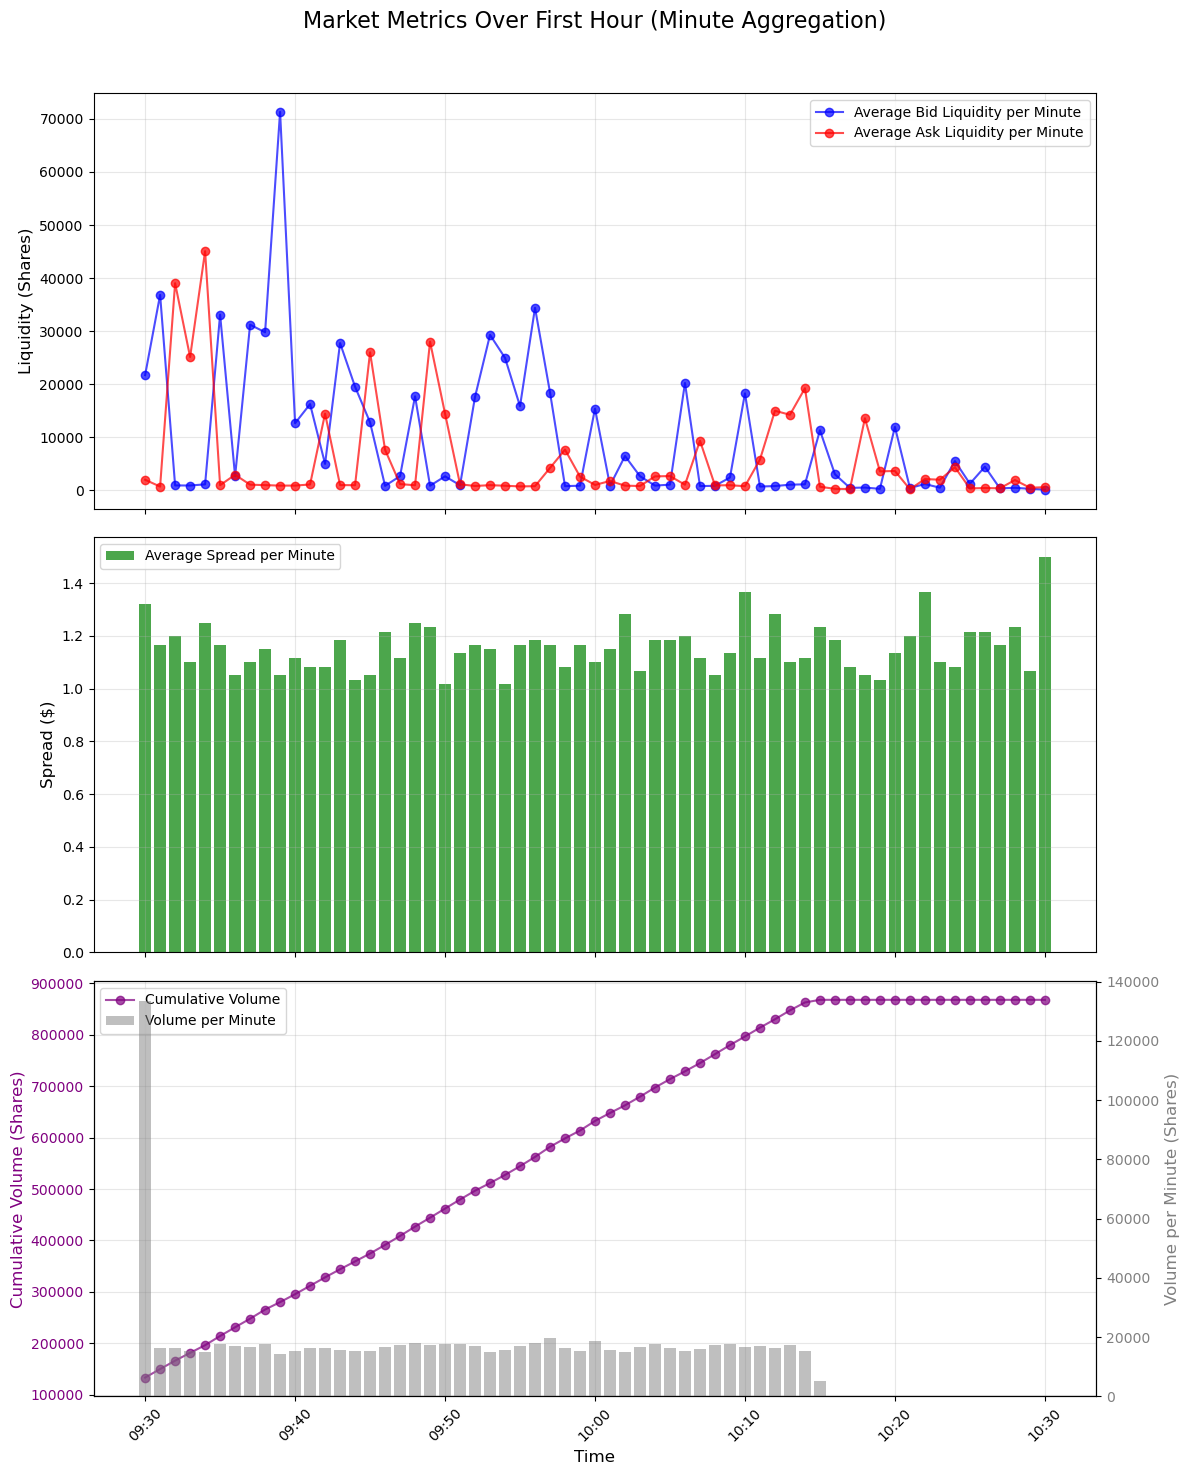

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# 读取快照数据
df = pd.read_pickle(r'log\rmsc03_two_hour\SNAPSHOT_AGENT.bz2')
df = df.reset_index()

# 确保EventTime为 datetime 类型并设置为索引
df['EventTime'] = pd.to_datetime(df['EventTime'])
df = df.set_index('EventTime').sort_index()

# 计算时间范围（取第一条记录时间作为起点，加1小时）
start_time = df.index[1]
end_time = start_time + pd.Timedelta(hours=1)
# 筛选前一小时的数据
df = df[(df.index >= start_time) & (df.index <= end_time)]

# 分离三种事件类型的数据
liquidity_events = df[df['EventType'] == 'LIQUIDITY_1PCT']
spread_events = df[df['EventType'] == 'SPREAD']
volume_events = df[df['EventType'] == 'VOLUME']

# 提取流动性数据并按分钟聚合
liquidity_data = pd.DataFrame({
    'bid_liquidity': [event['bid_liquidity'] for event in liquidity_events['Event']],
    'ask_liquidity': [event['ask_liquidity'] for event in liquidity_events['Event']]
}, index=liquidity_events.index)
# 按分钟聚合，计算每分钟平均值
liquidity_data_min = liquidity_data.resample('1min').mean().dropna()

# 提取价差数据并按分钟聚合
spread_data = pd.DataFrame({
    'spread': [event['spread'] for event in spread_events['Event']]
}, index=spread_events.index)
# 按分钟重采样并计算平均值
spread_data_min = spread_data.resample('1min').mean().dropna()

# 提取交易量数据并按分钟聚合
volume_data = pd.DataFrame({
    'volume': [event['volume'] for event in volume_events['Event']]
}, index=volume_events.index)
# 按分钟聚合交易量
volume_data_min = volume_data.resample('1min').sum().dropna()
# 计算累积交易量（按分钟）
volume_data_min['cumulative_volume'] = volume_data_min['volume'].cumsum()

# 创建可视化图表
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Market Metrics Over First Hour (Minute Aggregation)', fontsize=16)

# 1. 流动性图表（按分钟聚合）
axes[0].plot(liquidity_data_min.index, liquidity_data_min['bid_liquidity'], 
             label='Average Bid Liquidity per Minute', color='blue', alpha=0.7, marker='o')
axes[0].plot(liquidity_data_min.index, liquidity_data_min['ask_liquidity'], 
             label='Average Ask Liquidity per Minute', color='red', alpha=0.7, marker='o')
axes[0].set_ylabel('Liquidity (Shares)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# 2. 价差图表（按分钟聚合）
axes[1].bar(spread_data_min.index, spread_data_min['spread'], 
            label='Average Spread per Minute', color='green', alpha=0.7, width=0.8/24/60)
axes[1].set_ylabel('Spread ($)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# 3. 交易量图表（按分钟聚合）
ax2 = axes[2]  # 左侧主轴
ax3 = ax2.twinx()  # 创建右侧副轴

# 左侧轴：累积交易量（线图）
line = ax2.plot(volume_data_min.index, volume_data_min['cumulative_volume'], 
                label='Cumulative Volume', color='purple', alpha=0.7, marker='o')
ax2.set_ylabel('Cumulative Volume (Shares)', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# 右侧轴：每分钟交易量（柱状图）
bars = ax3.bar(volume_data_min.index, volume_data_min['volume'], 
               label='Volume per Minute', color='gray', alpha=0.5, width=0.8/24/60)
ax3.set_ylabel('Volume per Minute (Shares)', fontsize=12, color='gray')
ax3.tick_params(axis='y', labelcolor='gray')

# 合并图例
lines = line
labels = [l.get_label() for l in lines]
labels.append(bars.get_label())
ax2.legend(lines + [bars], labels, fontsize=10)

ax2.set_xlabel('Time', fontsize=12)
ax2.grid(alpha=0.3)

# 设置x轴时间格式
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 只显示小时和分钟
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为标题留出空间
plt.show()

# 保存图表
fig.savefig('market_metrics_all_minute_agg.png', dpi=300, bbox_inches='tight')

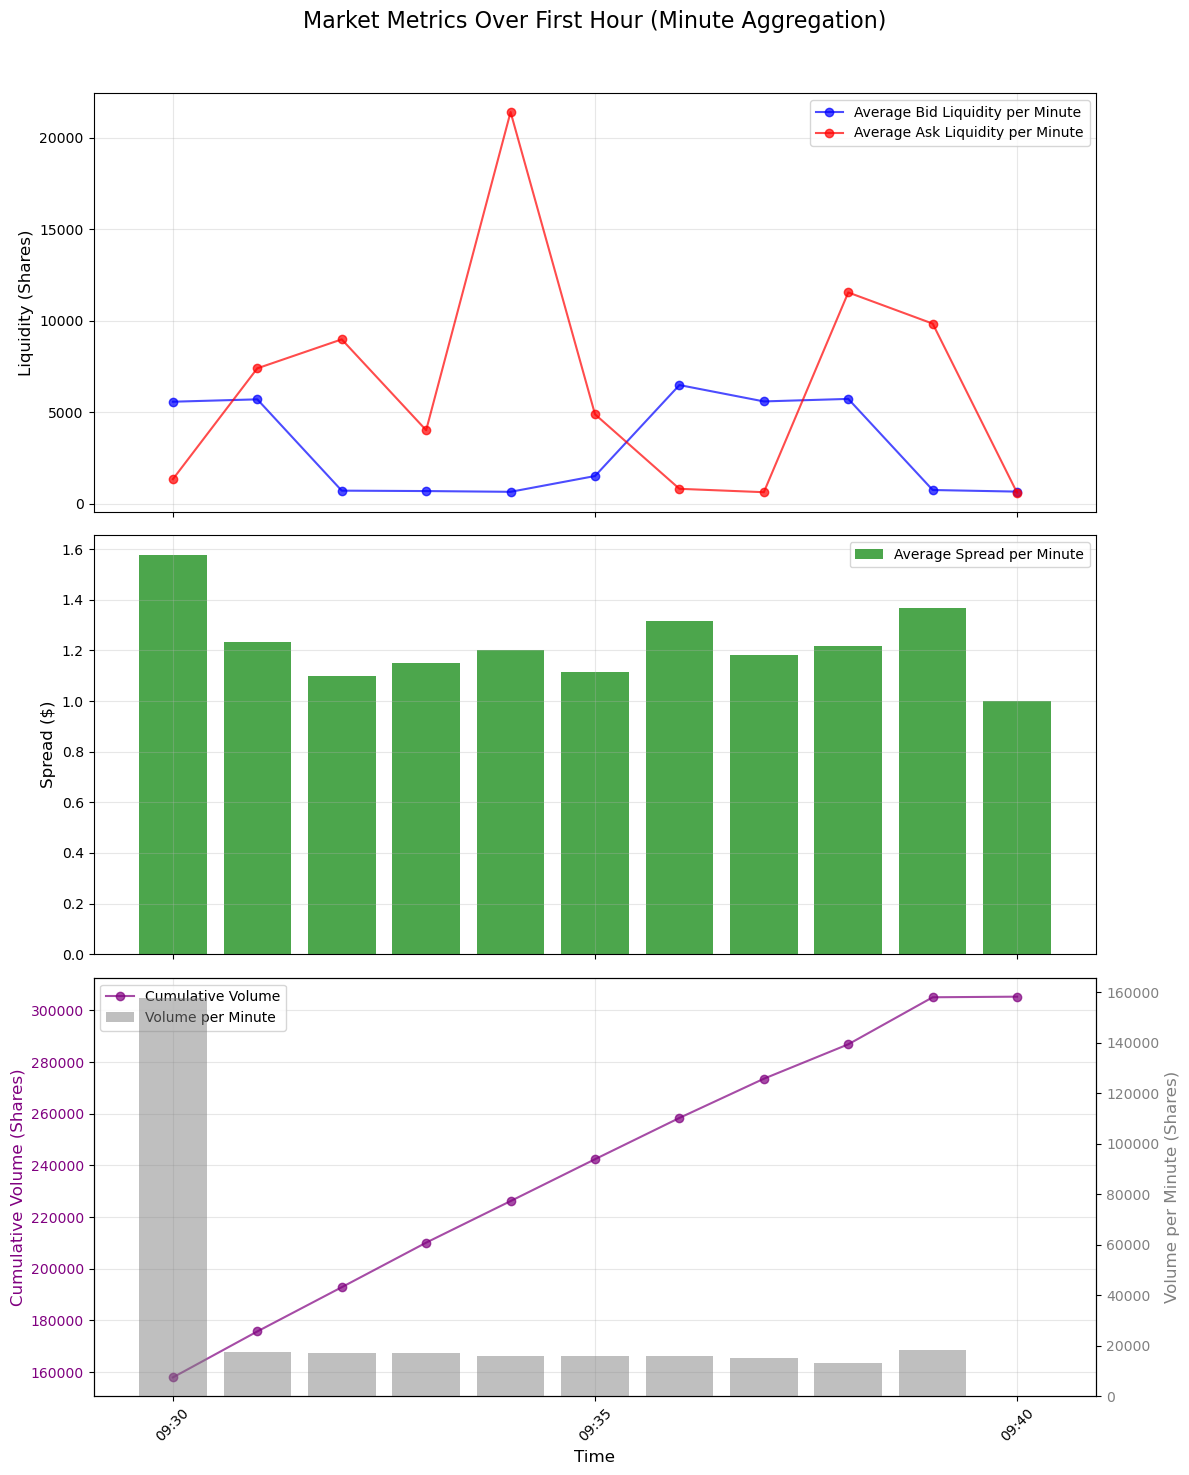

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# 读取快照数据
df = pd.read_pickle(r'log\rmsc04_two_hour\SNAPSHOT_AGENT.bz2')
df = df.reset_index()

# 确保EventTime为 datetime 类型并设置为索引
df['EventTime'] = pd.to_datetime(df['EventTime'])
df = df.set_index('EventTime').sort_index()

# 计算时间范围（取第一条记录时间作为起点，加1小时）
start_time = df.index[1]
end_time = start_time + pd.Timedelta(hours=1)
# 筛选前一小时的数据
df = df[(df.index >= start_time) & (df.index <= end_time)]

# 分离三种事件类型的数据
liquidity_events = df[df['EventType'] == 'LIQUIDITY_1PCT']
spread_events = df[df['EventType'] == 'SPREAD']
volume_events = df[df['EventType'] == 'VOLUME']

# 提取流动性数据并按分钟聚合
liquidity_data = pd.DataFrame({
    'bid_liquidity': [event['bid_liquidity'] for event in liquidity_events['Event']],
    'ask_liquidity': [event['ask_liquidity'] for event in liquidity_events['Event']]
}, index=liquidity_events.index)
# 按分钟聚合，计算每分钟平均值
liquidity_data_min = liquidity_data.resample('1min').mean().dropna()

# 提取价差数据并按分钟聚合
spread_data = pd.DataFrame({
    'spread': [event['spread'] for event in spread_events['Event']]
}, index=spread_events.index)
# 按分钟重采样并计算平均值
spread_data_min = spread_data.resample('1min').mean().dropna()

# 提取交易量数据并按分钟聚合
volume_data = pd.DataFrame({
    'volume': [event['volume'] for event in volume_events['Event']]
}, index=volume_events.index)
# 按分钟聚合交易量
volume_data_min = volume_data.resample('1min').sum().dropna()
# 计算累积交易量（按分钟）
volume_data_min['cumulative_volume'] = volume_data_min['volume'].cumsum()

# 创建可视化图表
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
fig.suptitle('Market Metrics Over First Hour (Minute Aggregation)', fontsize=16)

# 1. 流动性图表（按分钟聚合）
axes[0].plot(liquidity_data_min.index, liquidity_data_min['bid_liquidity'], 
             label='Average Bid Liquidity per Minute', color='blue', alpha=0.7, marker='o')
axes[0].plot(liquidity_data_min.index, liquidity_data_min['ask_liquidity'], 
             label='Average Ask Liquidity per Minute', color='red', alpha=0.7, marker='o')
axes[0].set_ylabel('Liquidity (Shares)', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# 2. 价差图表（按分钟聚合）
axes[1].bar(spread_data_min.index, spread_data_min['spread'], 
            label='Average Spread per Minute', color='green', alpha=0.7, width=0.8/24/60)
axes[1].set_ylabel('Spread ($)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# 3. 交易量图表（按分钟聚合）
ax2 = axes[2]  # 左侧主轴
ax3 = ax2.twinx()  # 创建右侧副轴

# 左侧轴：累积交易量（线图）
line = ax2.plot(volume_data_min.index, volume_data_min['cumulative_volume'], 
                label='Cumulative Volume', color='purple', alpha=0.7, marker='o')
ax2.set_ylabel('Cumulative Volume (Shares)', fontsize=12, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# 右侧轴：每分钟交易量（柱状图）
bars = ax3.bar(volume_data_min.index, volume_data_min['volume'], 
               label='Volume per Minute', color='gray', alpha=0.5, width=0.8/24/60)
ax3.set_ylabel('Volume per Minute (Shares)', fontsize=12, color='gray')
ax3.tick_params(axis='y', labelcolor='gray')

# 合并图例
lines = line
labels = [l.get_label() for l in lines]
labels.append(bars.get_label())
ax2.legend(lines + [bars], labels, fontsize=10)

ax2.set_xlabel('Time', fontsize=12)
ax2.grid(alpha=0.3)

# 设置x轴时间格式
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 只显示小时和分钟
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为标题留出空间
plt.show()

# 保存图表
fig.savefig('market_metrics_all_minute_agg.png', dpi=300, bbox_inches='tight')

C:\Users\JBY\AppData\Local\Temp\ipykernel_34092\3708816077.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(); axes[1].grid(alpha=0.3)


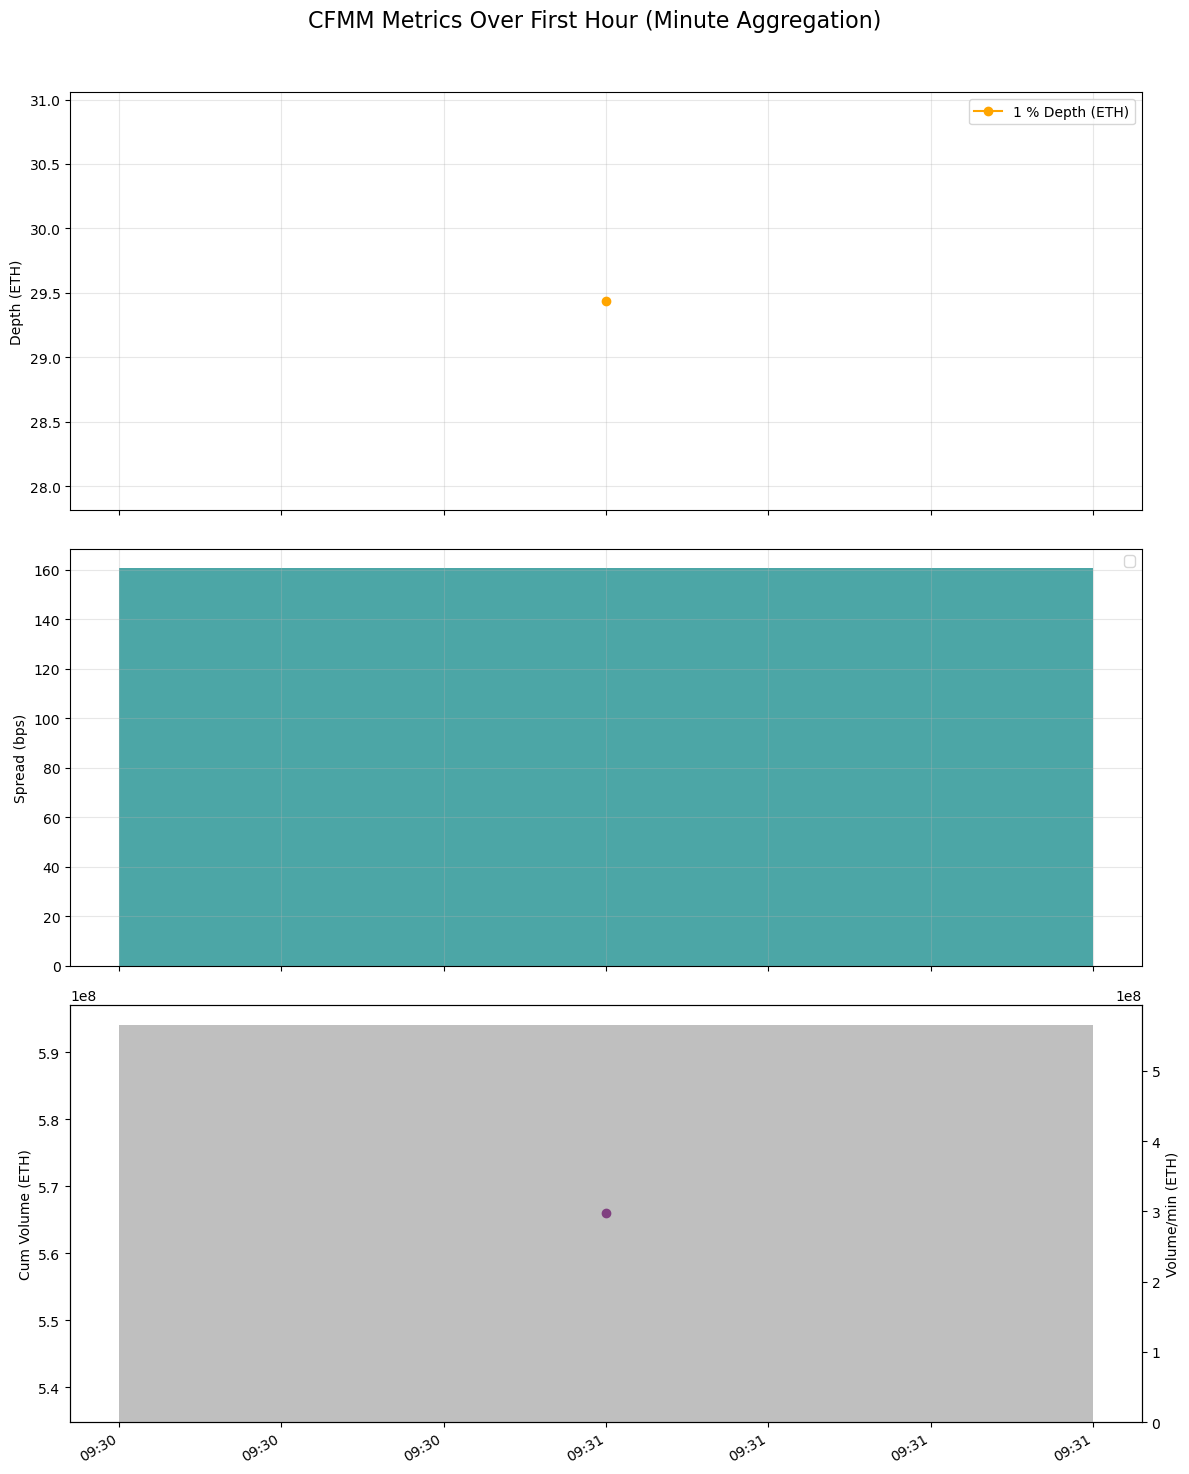

In [3]:
# 1. 读 CFMM 日志（同一 bz2 里已经同时记录了 CFMM 事件）
cfmm_spread = df[df['EventType'] == 'CFMM_SPREAD']
cfmm_depth  = df[df['EventType'] == 'CFMM_DEPTH_1PCT']
cfmm_vol    = df[df['EventType'] == 'CFMM_VOLUME']

# 2. 构造 DataFrame 并 1min 聚合
def make_cfmm_df(spread=None, depth=None, vol=None):
    dfs = []
    if spread is not None and not spread.empty:
        s = pd.DataFrame({
            'spread_bps': [e['spread_bps'] for e in spread['Event']]
        }, index=spread.index).resample('1min').mean()
        dfs.append(s)
    if depth is not None and not depth.empty:
        d = pd.DataFrame({
            'depth_eth': [e['depth_eth'] for e in depth['Event']]
        }, index=depth.index).resample('1min').mean()
        dfs.append(d)
    if vol is not None and not vol.empty:
        v = pd.DataFrame({
            'volume_eth': [e['volume_eth'] for e in vol['Event']]
        }, index=vol.index).resample('1min').sum()
        v['cumvol'] = v['volume_eth'].cumsum()
        dfs.append(v)
    return pd.concat(dfs, axis=1).dropna()

cfmm_min = make_cfmm_df(cfmm_spread, cfmm_depth, cfmm_vol)

def plot_cfmm(cfmm_min):
    fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    fig.suptitle('CFMM Metrics Over First Hour (Minute Aggregation)', fontsize=16)

    # 1. Depth
    axes[0].plot(cfmm_min.index, cfmm_min['depth_eth'],
                 color='orange', marker='o', label='1 % Depth (ETH)')
    axes[0].set_ylabel('Depth (ETH)')
    axes[0].legend(); axes[0].grid(alpha=0.3)

    # 2. Spread
    axes[1].bar(cfmm_min.index, cfmm_min['spread_bps'],
                color='teal', alpha=0.7, width=1/24/60)
    axes[1].set_ylabel('Spread (bps)')
    axes[1].legend(); axes[1].grid(alpha=0.3)

    # 3. Volume
    ax2 = axes[2]; ax3 = ax2.twinx()
    l1 = ax2.plot(cfmm_min.index, cfmm_min['cumvol'],
                  color='purple', marker='o', label='Cumulative Volume')
    b1 = ax3.bar(cfmm_min.index, cfmm_min['volume_eth'],
                 color='gray', alpha=0.5, width=1/24/60, label='Volume/min')
    ax2.set_ylabel('Cum Volume (ETH)')
    ax3.set_ylabel('Volume/min (ETH)')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig('cfmm_metrics_all_minute_agg.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_cfmm(cfmm_min)

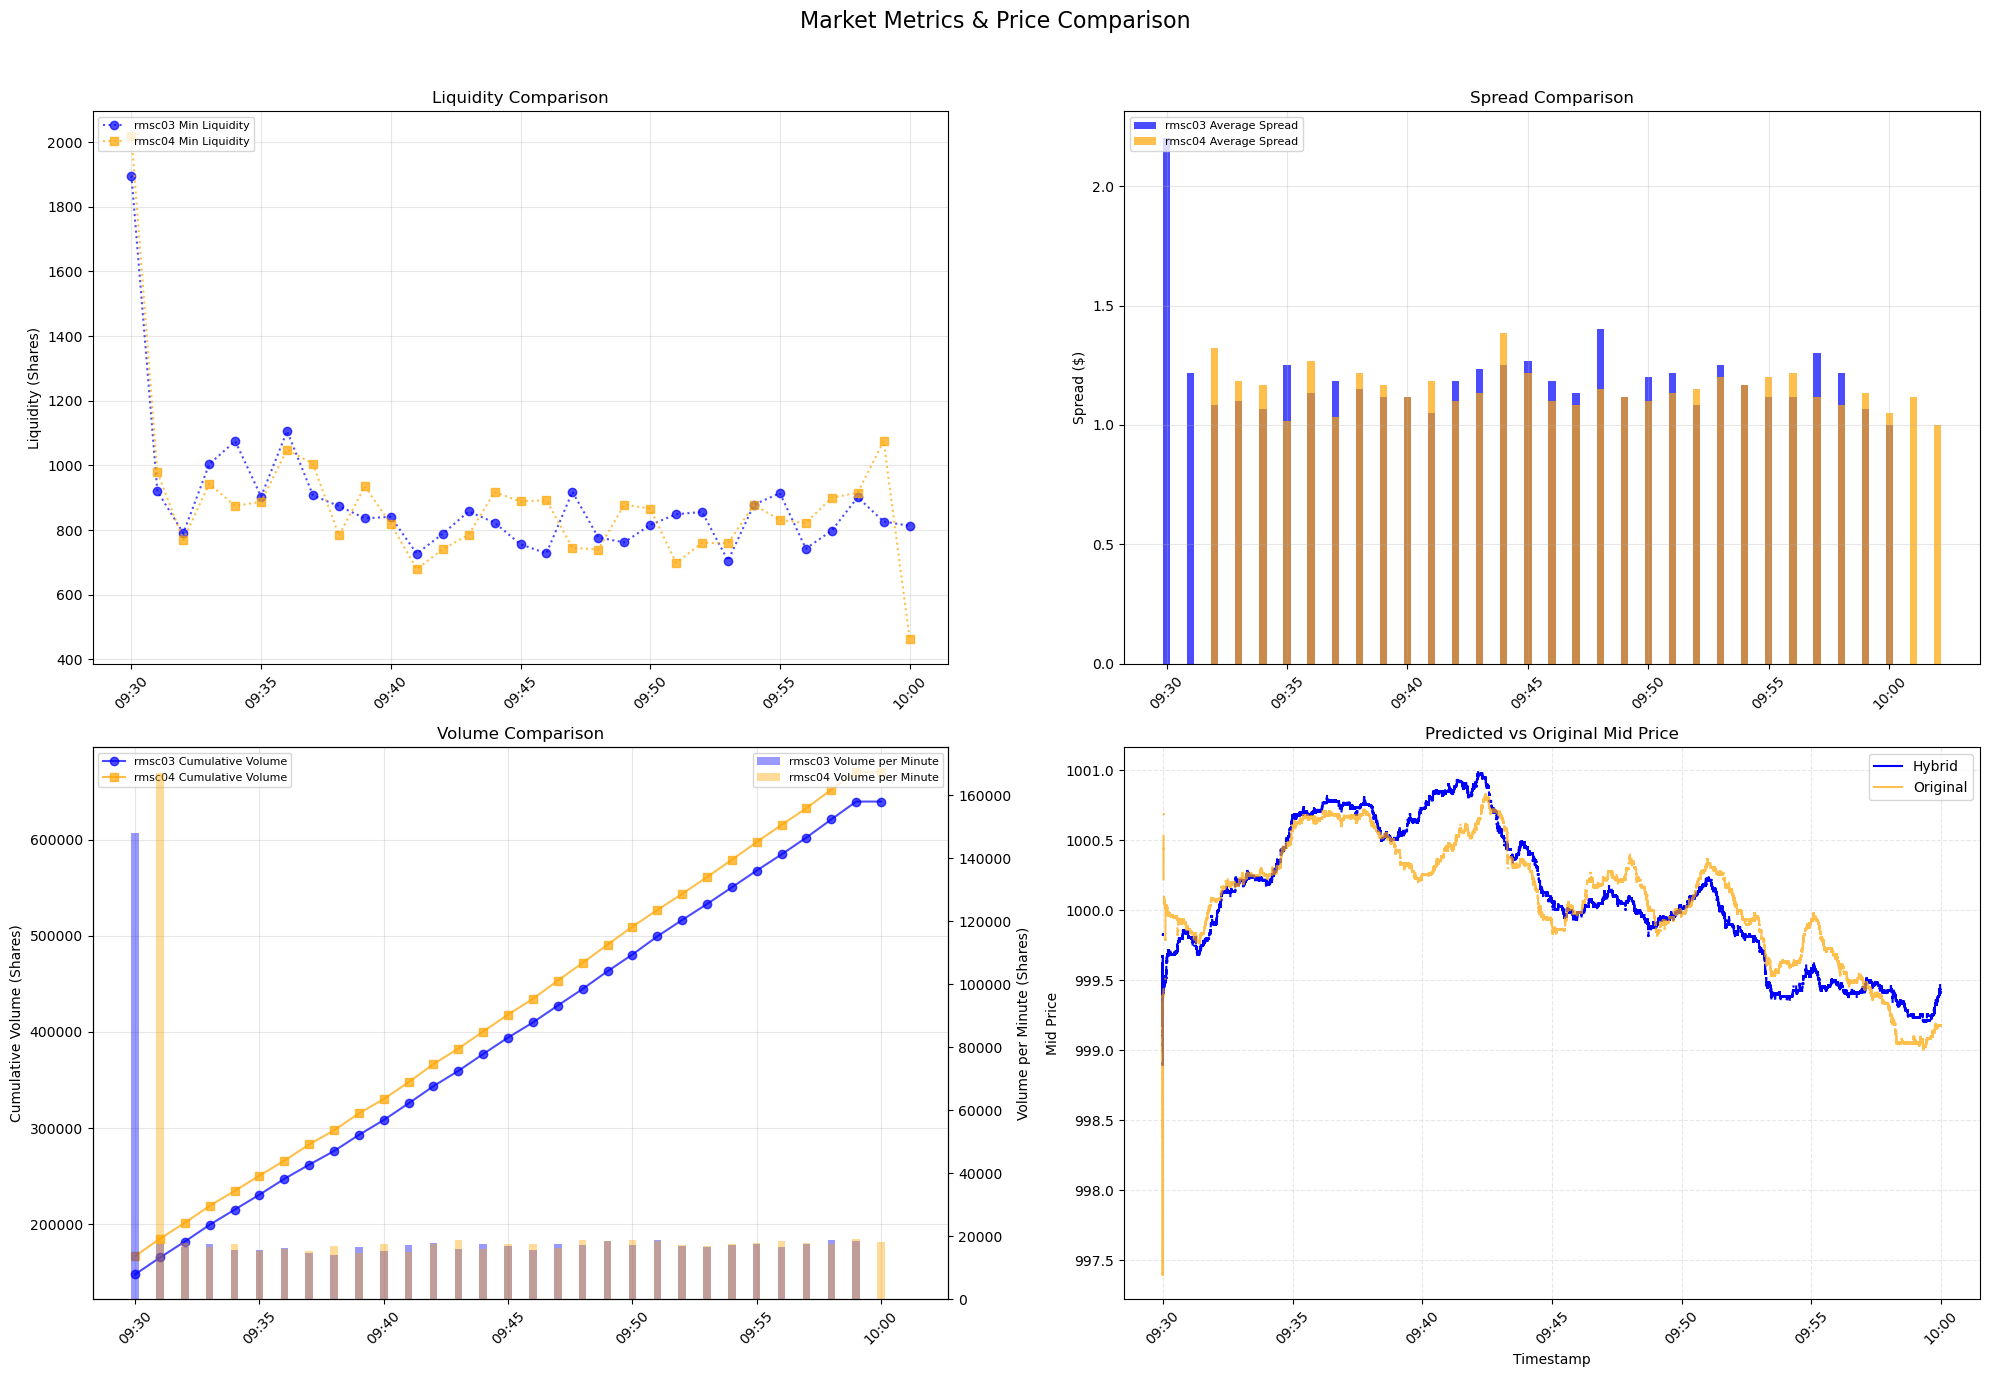

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def load_and_preprocess_data(file_path):
    """加载并预处理快照数据"""
    # 读取数据并重置索引
    df = pd.read_pickle(file_path)
    df = df.reset_index()
    
    # 转换时间格式并设置为索引
    df['EventTime'] = pd.to_datetime(df['EventTime'])
    df = df.set_index('EventTime').sort_index()
    
    # 筛选1小时数据（从第二条记录开始）
    if len(df) >= 2:  # 确保有足够数据
        start_time = df.index[1]
        end_time = start_time + pd.Timedelta(hours=1)
        return df[(df.index >= start_time) & (df.index <= end_time)]
    return pd.DataFrame()  # 空数据处理


def process_liquidity_events(df):
    """处理流动性事件数据并按分钟聚合，计算买卖方最小值"""
    if df.empty:
        return pd.DataFrame(columns=['bid_liquidity', 'ask_liquidity', 'min_liquidity'])
        
    liquidity_events = df[df['EventType'] == 'LIQUIDITY_1PCT']
    if liquidity_events.empty:
        return pd.DataFrame(columns=['bid_liquidity', 'ask_liquidity', 'min_liquidity'])
    
    # 提取流动性数据并计算最小值
    liquidity_data = pd.DataFrame({
        'bid_liquidity': [event['bid_liquidity'] for event in liquidity_events['Event']],
        'ask_liquidity': [event['ask_liquidity'] for event in liquidity_events['Event']]
    }, index=liquidity_events.index)
    liquidity_data['min_liquidity'] = liquidity_data[['bid_liquidity', 'ask_liquidity']].min(axis=1)
    
    # 按分钟聚合
    return liquidity_data.resample('1min').mean().dropna()


def process_spread_events(df):
    """处理价差事件数据并按分钟聚合"""
    if df.empty:
        return pd.DataFrame(columns=['spread'])
        
    spread_events = df[df['EventType'] == 'SPREAD']
    if spread_events.empty:
        return pd.DataFrame(columns=['spread'])
    
    spread_data = pd.DataFrame({
        'spread': [event['spread'] for event in spread_events['Event']]
    }, index=spread_events.index)
    
    return spread_data.resample('1min').mean().dropna()


def process_volume_events(df):
    """处理交易量事件数据并按分钟聚合"""
    if df.empty:
        return pd.DataFrame(columns=['volume', 'cumulative_volume'])
        
    volume_events = df[df['EventType'] == 'VOLUME']
    if volume_events.empty:
        return pd.DataFrame(columns=['volume', 'cumulative_volume'])
    
    volume_data = pd.DataFrame({
        'volume': [event['volume'] for event in volume_events['Event']]
    }, index=volume_events.index)
    
    volume_data_min = volume_data.resample('1min').sum().dropna()
    volume_data_min['cumulative_volume'] = volume_data_min['volume'].cumsum()
    return volume_data_min


def plot_mid_price_comparison(merged, ax, styles):
    """绘制中间价预测与原始值对比图"""
    # 预测值曲线
    ax.plot(merged.index, merged['mid_price_1_pred'], label='Hybrid', color='blue', linewidth=1.5)
    # 原始值曲线
    ax.plot(merged.index, merged['mid_price_1_origin'], label='Original', color=styles[name]['color'], linewidth=1.5, alpha=styles[name]['alpha'])

    # 图表美化
    ax.set_xlabel('Timestamp', fontsize=10)
    ax.set_ylabel('Mid Price', fontsize=10)
    ax.set_title('Predicted vs Original Mid Price', fontsize=12)
    ax.legend(fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(linestyle='--', alpha=0.3)


def plot_comparison_metrics(data_dict, merged):
    """绘制所有对比图表，使用2x2子图布局"""
    # 创建2x2子图
    fig, axes = plt.subplots(2, 2, figsize=(20, 14), sharex=False)
    fig.suptitle('Market Metrics & Price Comparison', fontsize=16)
    
    # 定义两个数据源的样式
    styles = {
        'rmsc03': {'color': 'blue', 'marker': 'o', 'alpha': 0.7},
        'rmsc04': {'color': 'orange', 'marker': 's', 'alpha': 0.7}
    }
    bar_width = 0.3/24/60  # 柱状图宽度
    
    # 1. 流动性对比图表 (0,0位置)
    ax1 = axes[0, 0]
    for name, data in data_dict.items():
        liq = data['liquidity']
        if not liq.empty:
            # # 显示bid流动性（实线）
            # ax1.plot(liq.index, liq['bid_liquidity'], 
            #              label=f'{name} Bid Liquidity', **styles[name])
            # # 显示ask流动性（虚线）
            # ax1.plot(liq.index, liq['ask_liquidity'], 
            #              label=f'{name} Ask Liquidity', linestyle='--',** styles[name])
            # 显示最小流动性（点线）
            ax1.plot(liq.index, liq['min_liquidity'], 
                         label=f'{name} Min Liquidity', linestyle=':', **styles[name])


        # liq = data['liquidity']
        # if not liq.empty:
        #     ax1.plot(liq.index, liq['min_liquidity'], 
        #              label=f'{name} Min Liquidity', linestyle=':', **styles[name])
    
    ax1.set_ylabel('Liquidity (Shares)', fontsize=10)
    ax1.legend(fontsize=8, loc='upper left')
    ax1.grid(alpha=0.3)
    ax1.set_title('Liquidity Comparison', fontsize=12)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. 价差对比图表 (0,1位置)
    ax2 = axes[0, 1]
    for i, (name, data) in enumerate(data_dict.items()):
        spread = data['spread']
        if not spread.empty:
            ax2.bar(spread.index + pd.Timedelta(minutes=i*2), 
                    spread['spread'], width=bar_width,
                    label=f'{name} Average Spread', color=styles[name]['color'], 
                    alpha=styles[name]['alpha'])
    
    ax2.set_ylabel('Spread ($)', fontsize=10)
    ax2.legend(fontsize=8, loc='upper left')
    ax2.grid(alpha=0.3)
    ax2.set_title('Spread Comparison', fontsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. 交易量对比图表 (1,0位置)
    ax3 = axes[1, 0]
    for name, data in data_dict.items():
        volume = data['volume']
        if not volume.empty:
            # 左侧轴：累积交易量
            ax3.plot(volume.index, volume['cumulative_volume'],
                     label=f'{name} Cumulative Volume',** styles[name])
            
            # 右侧轴：每分钟交易量
            if not hasattr(ax3, 'twin_ax'):
                ax3.twin_ax = ax3.twinx()
            ax3.twin_ax.bar(volume.index + pd.Timedelta(minutes=1 if name == 'rmsc04' else 0),
                            volume['volume'], width=bar_width,
                            label=f'{name} Volume per Minute', 
                            color=styles[name]['color'], alpha=0.4)
    
    ax3.set_ylabel('Cumulative Volume (Shares)', fontsize=10)
    ax3.twin_ax.set_ylabel('Volume per Minute (Shares)', fontsize=10)
    ax3.legend(fontsize=8, loc='upper left')
    ax3.twin_ax.legend(fontsize=8, loc='upper right')
    ax3.grid(alpha=0.3)
    ax3.set_title('Volume Comparison', fontsize=12)
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. 中间价对比图表 (1,1位置)
    plot_mid_price_comparison(merged, axes[1, 1], styles)
    axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # 调整布局并保存图表
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig('market_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    # 定义数据源路径
    data_paths = {
        'rmsc03': r'log\rmsc03_two_hour\SNAPSHOT_AGENT.bz2',
        'rmsc04': r'log\rmsc04_two_hour\SNAPSHOT_AGENT.bz2'
    }
    
    # 批量处理市场指标数据
    data_dict = {}
    for name, path in data_paths.items():
        raw_data = load_and_preprocess_data(path)
        data_dict[name] = {
            'liquidity': process_liquidity_events(raw_data),
            'spread': process_spread_events(raw_data),
            'volume': process_volume_events(raw_data)
        }
    
    # 处理中间价数据
    origin = pd.read_csv(r'log\rmsc03_two_hour\mid_price.csv')
    pred = pd.read_csv(r'log\rmsc04_two_hour\mid_price.csv')
    
    # 转换时间格式并设置为索引
    pred['timestamp'] = pd.to_datetime(pred['timestamp'])
    pred.set_index('timestamp', inplace=True)
    
    origin['timestamp'] = pd.to_datetime(origin['timestamp'])
    origin.set_index('timestamp', inplace=True)
    
    # 外连接合并并排序
    merged = pred.join(origin, lsuffix='_pred', rsuffix='_origin', how='outer')
    merged.sort_index(inplace=True)
    
    # 绘制所有对比图表
    plot_comparison_metrics(data_dict, merged)

In [ ]:
cmd = '''
python -u abides.py -c rmsc03 -t ETH -d 20251028 -s 1235 -l rmsc03_two_hour --end-time 10:00:00

python -u abides.py -c rmsc04 -t ETH -d 20251028 -s 1235 -l rmsc04_two_hour --end-time 10:00:00 -k 100000000 --fee 0.003

python ttest.py
'''

